# Tutorial 2: Entanglement Forging with Quantum Serverless

**Entanglement forging** is a method which allows us to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical optimization, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

See [Tutorial 1](../../../docs/tutorials/entanglement_forging/tutorial_1_H2.ipynb) for a high-level breakdown of the entanglement forging algorithm, or check out the [explanatory material](../../../docs/explanation/entanglement_forging/index.rst) for a more detailed explanation.

### Adapting entanglement forging for use with `Quantum Serverless`

[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to configure a ground state workflow with entanglement forging and seamlessly adapt it to run entirely on the cloud using Quantum Serverless.

### Instantiate the `ElectronicStructureProblem`

For this tutorial, we will model a system in which H2O is split on a magnesium surface, as described in Fig. 1(a) from [arXiv:2203.07536](https://arxiv.org/abs/2203.07536). In particular, we'll compute the ground state energy of the reactant in this reaction. Entanglement forging reduces the total number of qubits needed from 4 to 2.

Here we read in the system information, populate an `IntegralDriver` object from `Circuit Knitting Toolbox`, and use that driver to instantiate an `ElectronicStructureProblem` from Qiskit.

In [1]:
from pathlib import Path
import numpy as np
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from circuit_knitting_toolbox.utils import IntegralDriver

system_data = np.load(Path("data") / "reactant_2mo.npz")
num_molecular_orbitals = 2

driver = IntegralDriver(
    hcore=system_data["h1"],
    mo_coeff=system_data["HF_mo_coeff"],
    eri=system_data["Gamma_eri"],
    num_alpha=system_data["na"],
    num_beta=system_data["nb"],
    nuclear_repulsion_energy=system_data["h0"],
)

problem = ElectronicStructureProblem(driver)

### Configure the entanglement forging specific inputs

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the [explanatory_material](../../../docs/explanation/entanglement_forging/index.rst) for additional background on the method). For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) circuit from Qiskit, along with [hop gates](https://doi.org/10.1103/PRXQuantum.3.010309).

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="hop_gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

print(f"Hop gate:\n{hop_gate.draw()}")

Hop gate:
     ┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘     


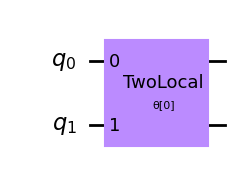

In [3]:
from qiskit.circuit.library import TwoLocal
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz

entangler_map = [[0, 1]]
bitstrings_u = [(1, 0), (0, 1)]

circuit_u = TwoLocal(num_molecular_orbitals, [], hop_gate, entangler_map, reps=1)
ansatz = EntanglementForgingAnsatz(
    circuit_u=circuit_u,
    bitstrings_u=bitstrings_u,
)
ansatz.circuit_u.draw("mpl")

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

Alternatively, if a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

### Set up Quantum Serverless

We can use Quantum Serverless to send the entanglement forging routine to a remote compute resource. For this tutorial, we will use our local CPU cores as the compute cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more informatin about how to use other clusters.

In [5]:
from quantum_serverless import QuantumServerless

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

### Create a wrapper function to send to the remote cluster

Use Quantum Serverless to send the solve_remote method to a remote cluster.

Here we create a wrapper function for `EntanglementForgingGroundStateSolver` and its solve method, and we annotate it with the `@run_qiskit_remote()` decorator from Quantum Serverless. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [6]:
from typing import Optional, Sequence, Tuple, Dict
from qiskit.algorithms.optimizers import Optimizer
from qiskit.result import Result
from quantum_serverless import run_qiskit_remote
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)


@run_qiskit_remote()
def solve_remote(
    problem: ElectronicStructureProblem,
    ansatz_circuit: EntanglementForgingAnsatz,
    optimizer: Optimizer,
    service_args: Optional[Dict] = None,
    backend_names: Optional[Sequence[str]] = None,
    initial_point: Optional[Sequence[float]] = None,
    orbitals_to_reduce: Optional[Sequence[int]] = None,
) -> Result:
    """
    Wrapper function for running entanglement forging VQE on a remote resource.

        Args:
            - problem: A class encoding the problem to be solved
            - ansatz: The ansatz
            - optimizer: Optimizer to use to optimize the ansatz circuit parameters
            - service_args: The arguments for instantiating a QiskitRuntimeService
            - backend_names: List of backend names to use during parallel computation
            - initial_point: Initial values for ansatz parameters
            - orbitals_to_reduce: List of orbital indices to remove from the problem before
                decomposition.
        Returns:
            - An interpreted EigenstateResult
    """
    service = QiskitRuntimeService(**service_args) if service_args else None

    solver = EntanglementForgingGroundStateSolver(
        ansatz=ansatz,
        service=service,
        optimizer=optimizer,
        backend_names=backend_names,
        initial_point=initial_point,
        orbitals_to_reduce=orbitals_to_reduce,
    )
    result = solver.solve(problem)

    return result

### Run entanglement forging on a remote cluster

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`, which we have wrapped in the `solve_remote` function.

We will call the `solve_remote` function within a QuantumServerless context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [7]:
%%capture

from qiskit.algorithms.optimizers import COBYLA
from quantum_serverless import get

optimizer = COBYLA()
service_args = None if service is None else service.active_account()

with serverless:
    forging_result_future = solve_remote(
        problem,
        ansatz,
        optimizer,
        service_args=service_args,
        backend_names=backend_names,
    )
    results = get(forging_result_future)

### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


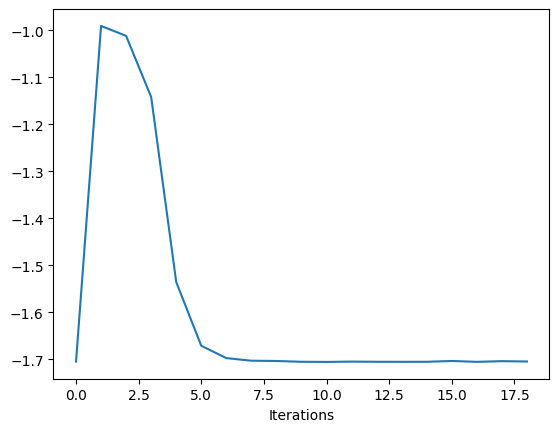

Schmidt Coefficients:


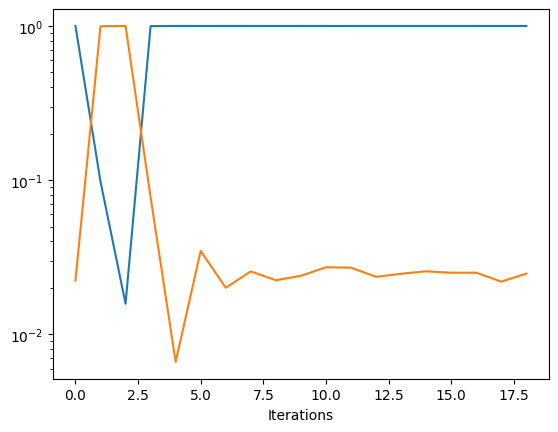

Parameters:


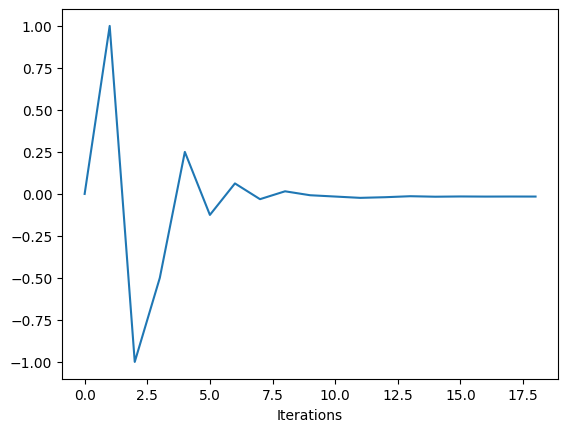

In [8]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.